In [1]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import math
import pprint
import itertools as it
import pyreason as pr



In [2]:
#---- lets read a file containing 
#   "circuit ESNET-Z10712 connects router anl541b-cr6 interface 2/1/c31/1 with router star-cr6 interface 2/1/c34/1" 
#---- and convert it into 2 graphs, a toplogy graph and a simple dependency graph


#--- g is the network topology
g = nx.Graph()#--- mincut etc dont support multigraph yet nx.MultiGraph()

#---deps is the network dependency graph, vlan depends on ckts[a,b,c] type thing
deps = nx.MultiDiGraph()

routers = {}
interfaces = {}
circuits = {}

with open("./topology.txt",'r') as f:
    lines = f.readlines()
    
for line in lines:
    x = line.split()
    ckt  =  x[1]
    rtr_a = x[4]
    if_a  = rtr_a+":"+x[6]
    rtr_z = x[9]
    if_z  = rtr_z+":"+x[11].split('.')[0]

    if rtr_a not in routers:
        routers[rtr_a] = 1
        g.add_node(rtr_a,label=rtr_a,type="router",weight=10)
        deps.add_node(rtr_a,label=rtr_a,type="router",weight=10,state="up")
        
    if if_a not in interfaces:
        interfaces[if_a] = 1
        label=x[6]
        g.add_node(if_a,type="interface",label="",weight=1)
        g.add_edge(if_a,rtr_a, type="if2rtr",weight=.5,state=1,capacity=400,label=if_a,ckt=ckt) #--- replace with real capacity someday

        deps.add_node(if_a,type="interface",weight=10,label=x[6],state=1)
        deps.add_edge(if_a,rtr_a, type="depends_on",weight=10,capacity=400,label=if_a,ckt=ckt,depset=0,depends_on=1,hw_dep=1) #--- replace with real capacity someday

    if rtr_z not in routers:
        routers[rtr_z] = 1
        g.add_node(rtr_z,label=rtr_z,type="router",weight=10)
        deps.add_node(rtr_z,label=rtr_z,type="router",weight=10,state=1)
        
    if if_z not in interfaces:
        interfaces[if_z] = 1
        label = x[11]
        g.add_node(if_z,type="interface",label="",weight=1,state=1) 
        g.add_edge(if_z,rtr_z,type="if2rtr",weight=.5,connects=1,capacity=400,label=if_z,ckt=ckt)

        deps.add_node(if_z,type="interface",weight=10,label=x[11].split('.')[0],state=1)
        deps.add_edge(if_z,rtr_z,type="depends_on",weight=10,connects=1,capacity=400,label=if_z,ckt=ckt,depset=0,depends_on=1,hw_dep=1)

    if ckt not in circuits:
        circuits[ckt] = 1
        g.add_edge(if_a,if_z,key=ckt,label=ckt,type="ckt",weight=1.75,capacity=400,distance=1,connects=1,ckt=ckt)

        deps.add_node(ckt,type="ckt",weight=10,label=ckt,state=1)
        deps.add_edge(ckt,if_a,type="depends_on",weight=10,depset=0,depends_on=1,ep_dep=1)
        deps.add_edge(ckt,if_z,type="depends_on",weight=10,depset=1,depends_on=1,ep_dep=1)




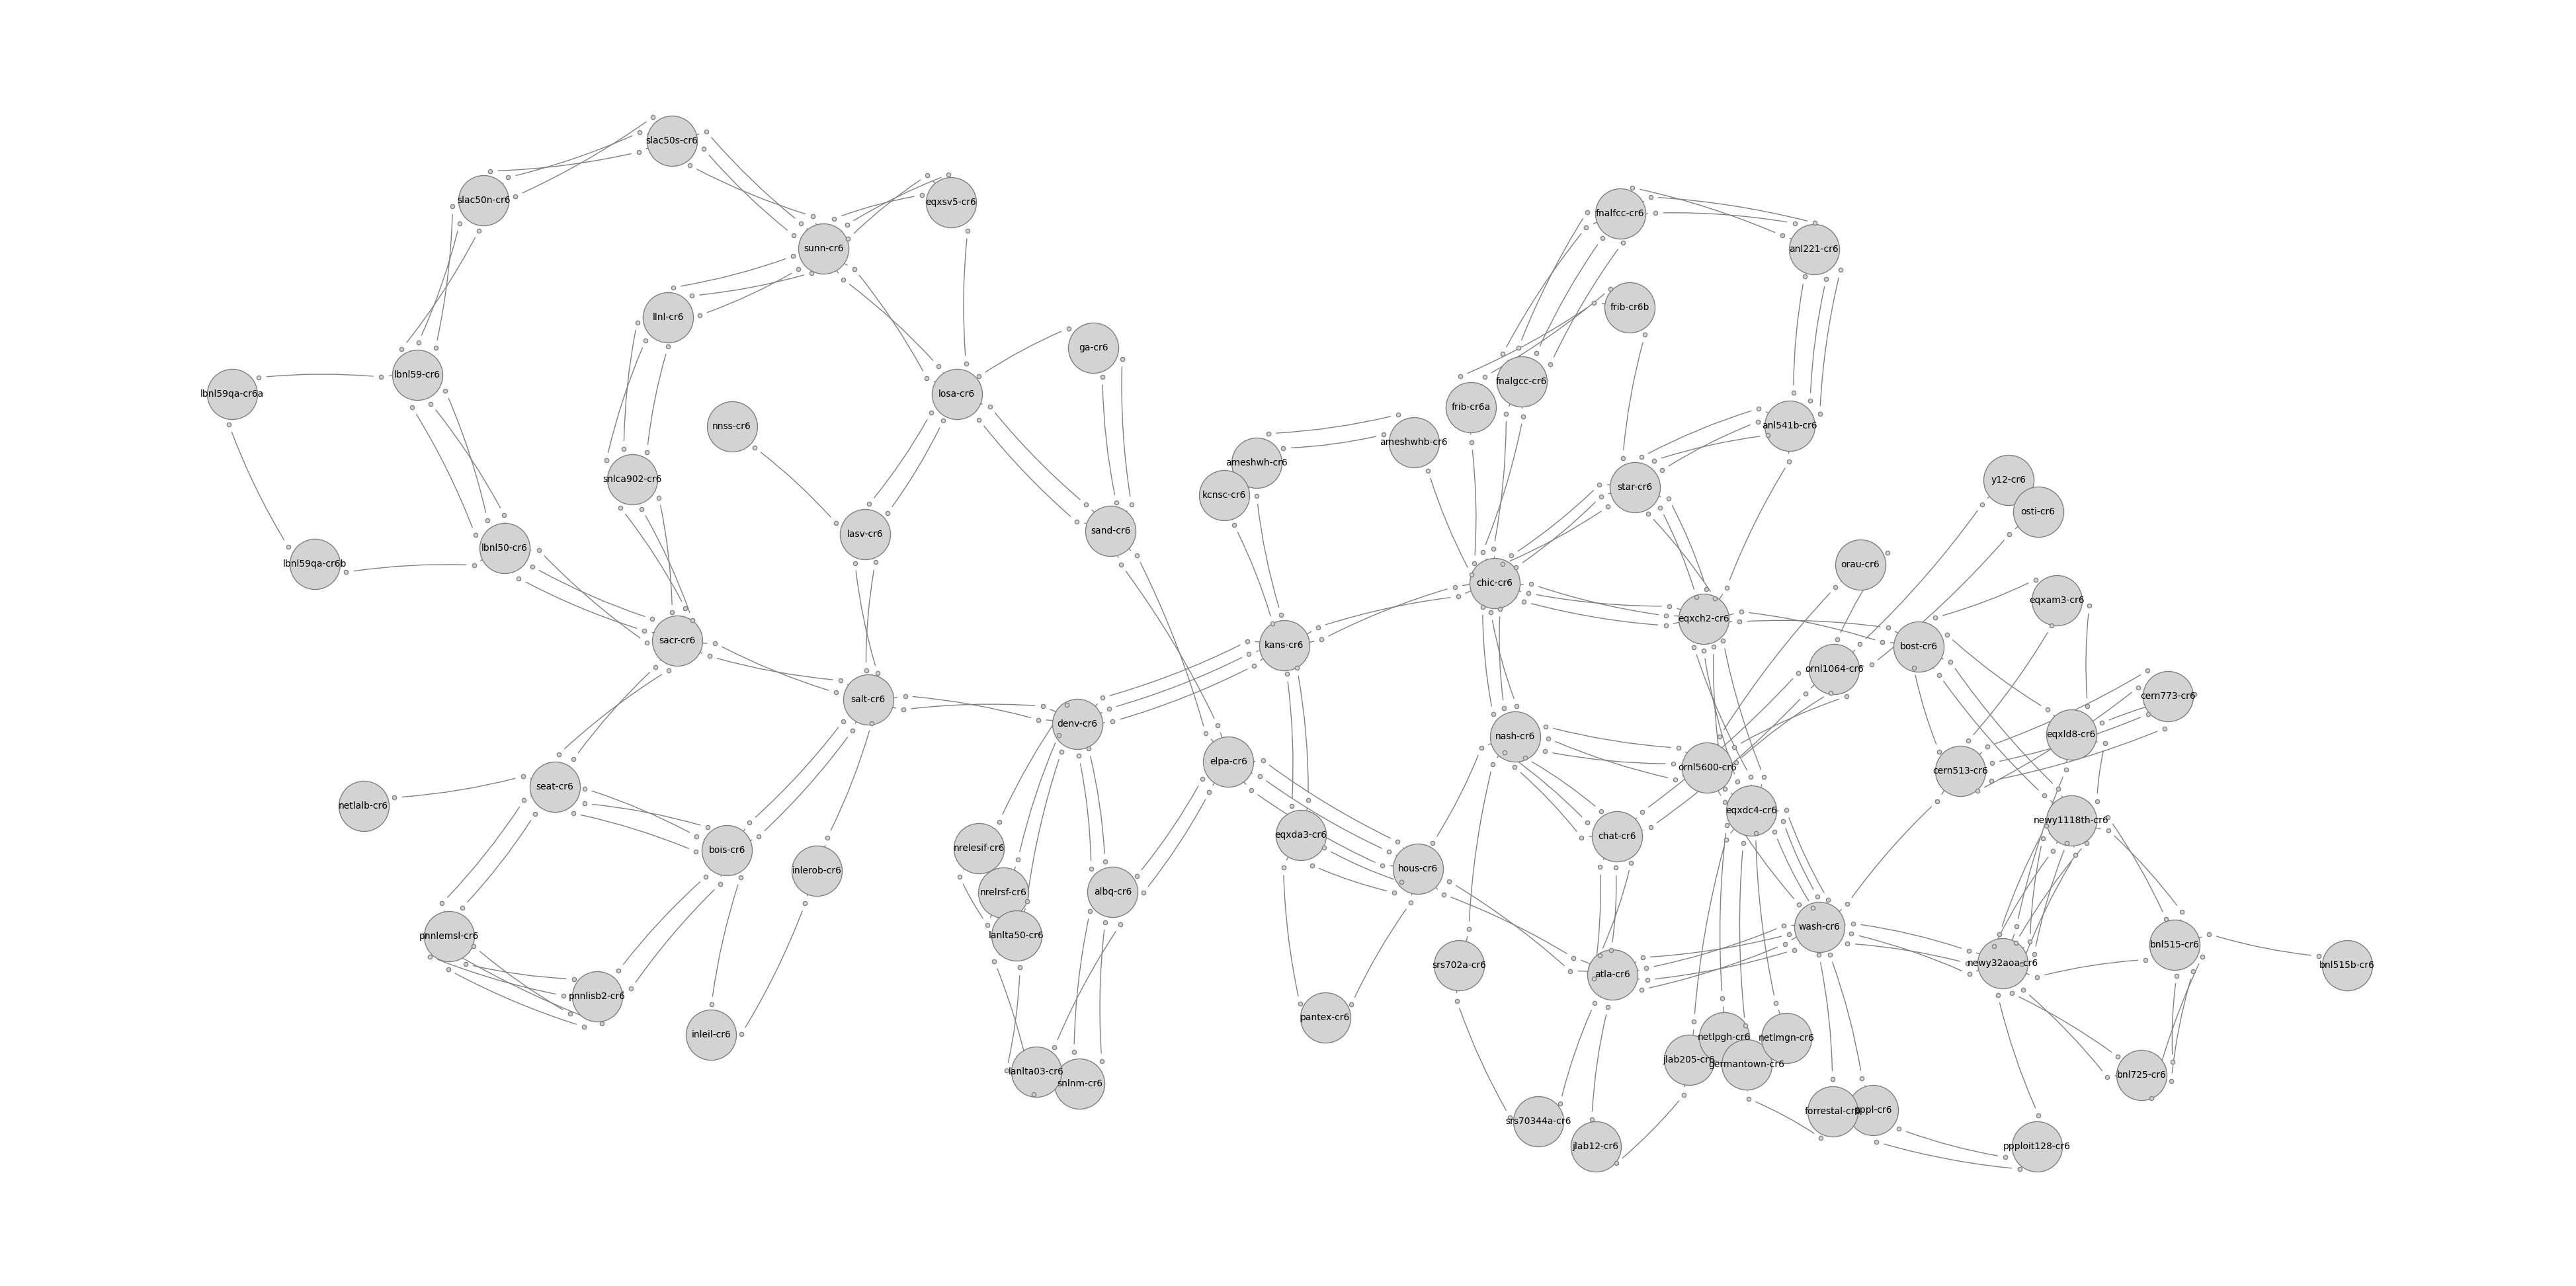

In [3]:
def draw_topo(g):
    bbckts = ckts       = [(u,v) for (u,v, d) in g.edges(data=True) ]
    routers    =  [(x) for (x, d) in g.nodes(data=True) if  d['type'] == 'router'  ]
    circuits   =  [(x) for (x, d) in deps.nodes(data=True) if  d['type'] == 'ckt'  ]
    router_size = {}
    router_mass = {}

    for node in g.nodes(data=True):
        router_size[node[0]] = 17
        router_mass[node[0] ] = 16

#pprint.pp(router_weights)

    fig = plt.figure(figsize=(50,25))
    ax = fig.add_subplot(111)

#pos = nx.nx_agraph.graphviz_layout(g,prog="neato")
    pos = nx.kamada_kawai_layout(g,weight="weight")
#pos = nx.forceatlas2_layout(g,scaling_ratio=1.4,dissuade_hubs=False,max_iter=4000,distributed_action=True,node_size=router_size,node_mass=router_mass)
# nodes
#pos = nx.spring_layout(g)
    nx.draw_networkx_nodes(routers, pos, node_size=3000,node_color="lightgrey",edgecolors="grey",linewidths=1)
    nx.draw_networkx_nodes(interfaces, pos, node_size=20,node_color="lightgrey",edgecolors="grey",linewidths=1)

# edges
    connectionstyle = [f"arc3,rad={r}" for r in it.accumulate([0.05] * 4)]
    nx.draw_networkx_edges(g, pos, width=1,alpha=1,edge_color="grey",connectionstyle=connectionstyle,ax=ax,arrows=True)

# node labels
    node_labels = nx.get_node_attributes(g, "label")
    nx.draw_networkx_labels(g, pos,node_labels, font_size=10, font_family="sans-serif")
# edge weight labels

#edge_labels = nx.get_edge_attributes(g, "label")
#nx.draw_networkx_edge_labels(g, pos,edge_labels,font_size=8,font_family="sans-serif",alpha=.5,font_color="green")

#ax = plt.gca()
#ax.margins(0.08)
    plt.axis("off")
#plt.tight_layout()
    plt.show()
#reason = pr.load_graph(g)

draw_topo(g)

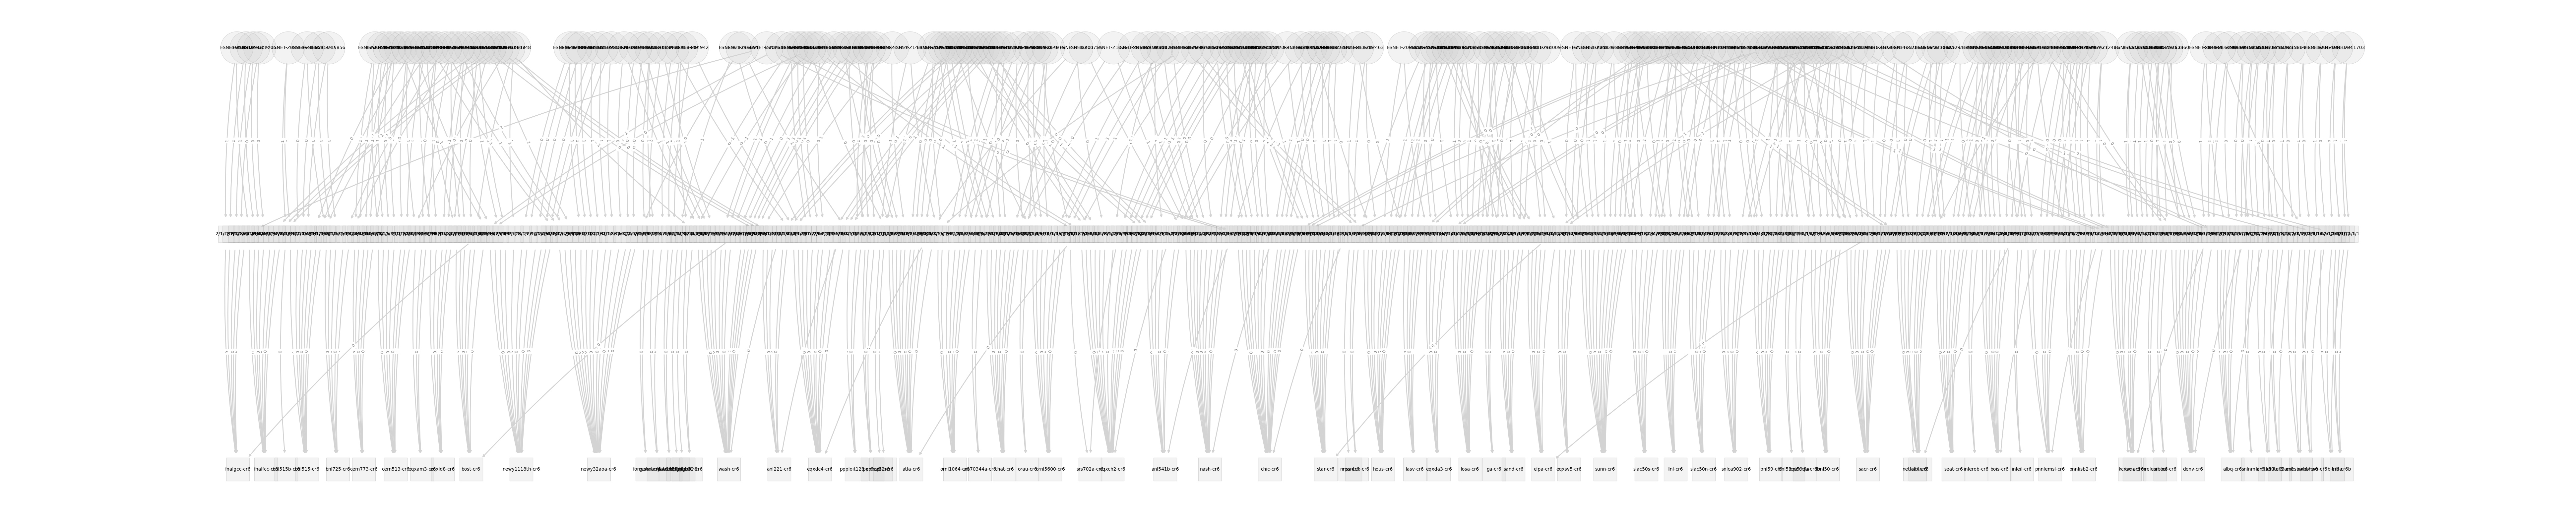

In [4]:


#---- show dependency graph
def draw_depgraph(deps,attr,highlight1,highlight2,start):

    subg = deps
    fig = plt.figure(figsize=(100,20))

    if start is not None and start != "":
        print ("only show dependencies of "+start)
        subg = deps.subgraph(sorted(nx.descendants(deps,start) | {start}))
        fig = plt.figure(figsize=(20,20))

    ax = fig.add_subplot(111)
    
    vlans_as_nodes   =  [(x) for (x, d) in subg.nodes(data=True) if  d['type'] == 'vlan'  ]
    vlps_as_nodes    =  [(x) for (x, d) in subg.nodes(data=True) if  d['type'] == 'vlan_path'  ]
    routers          =  [(x) for (x, d) in subg.nodes(data=True) if  d['type'] == 'router'  ]
    circuits         =  [(x) for (x, d) in subg.nodes(data=True) if  d['type'] == 'ckt'  ]
    interfaces       =  [(x) for (x, d) in subg.nodes(data=True) if  d['type'] == 'interface'  ]
    dwdms            =  [(x) for (x, d) in subg.nodes(data=True) if  d['type'] == 'dwdm'  ]

    if highlight1:
        hl1     = [(x) for (x, d) in subg.nodes(data=True) if   highlight1 in d]

    if highlight2:
        hl2     = [(x) for (x, d) in subg.nodes(data=True) if   highlight2 in d]

    bc = "lightgrey"
    #--- use dot with its hierarchial layering, good for dependency 
    pos2 = nx.nx_agraph.graphviz_layout(subg, prog="dot", args='-Gnodesep=.2 -Granksep=.2')#, root=vlans_as_nodes[0]) #, args="-Grankdir=LR -Goverlap_scaling=.5 -Gordering=out")

    #---- highlight in order or importance so that most important overrides
    nx.draw_networkx_nodes(hl2,pos2,ax=ax,node_color="orange",node_size=1000)
    nx.draw_networkx_nodes(hl1,pos2,ax=ax,node_color="red",node_size=1000)

    #--- draw the rest on top so text is readable
    nx.draw_networkx_nodes(dwdms, pos2, ax=ax,node_size=5000,node_color=bc,alpha=.25,node_shape="*",edgecolors="grey",linewidths=1)
    nx.draw_networkx_nodes(routers, pos2,ax=ax, node_size=2500,node_color=bc,alpha=.25,node_shape="s",edgecolors="grey",linewidths=1)
    nx.draw_networkx_nodes(interfaces, pos2,ax=ax, node_size=1250,node_color=bc,alpha=.25,node_shape='s',edgecolors="grey",linewidths=1)
    nx.draw_networkx_nodes(circuits, pos2,ax=ax, node_size=5000,node_color=bc,alpha=.25,edgecolors="grey",linewidths=1)
    nx.draw_networkx_nodes(vlps_as_nodes, pos2, ax=ax,node_size=7500,node_color=bc,alpha=.25,edgecolors="grey",linewidths=1)
    nx.draw_networkx_nodes(vlans_as_nodes, pos2, ax=ax,node_size=10000,node_color=bc,alpha=.25,edgecolors="grey",linewidths=1)


    #--- use curvy lines for dependencies
    connectionstyle = [f"Arc3, rad={r}" for r in it.accumulate([.05] * 4)]
    nx.draw_networkx_edges(subg,pos2,ax=ax,edge_color="lightgrey",width=2,node_size=5000,connectionstyle=connectionstyle,arrows=True)

    #--- add some labels
    node_labels = nx.get_node_attributes(subg, attr)
    nx.draw_networkx_labels(subg, pos2,node_labels,ax=ax, font_size=10, font_family="sans-serif")
    edge_labels = nx.get_edge_attributes(subg, "depset")
    nx.draw_networkx_edge_labels(subg, pos2,edge_labels,ax=ax,font_size=9,font_family="sans-serif",alpha=.5,font_color="black",connectionstyle=connectionstyle)

    plt.axis("off")
    plt.show()

#--- this will look like an angry mess as its the whole network
draw_depgraph(deps,"label","none","none","")

In [5]:
#--- lets create a  fictional vlan with explicit path so that we have a circuit heirarchy to play with

a_end = "newy32aoa-cr6"
z_end = "eqxdc4-cr6"

results = dict(nx.all_pairs_dijkstra(g,weight="weight"))

#pprint.pp(results['chic-cr6'][1]['losa-cr6'])
#pprint.pp(results['cern513-cr6'][1]['sand-cr6'])

nodes= results[a_end][1][z_end]

#---- create the vlan
vlan = "vl-"+a_end+"-"+z_end+"-1"
vlan_path = vlan+"-p0"

g.add_edge(nodes[0],nodes[-1],key=vlan,label=ckt,type="vlan",weight=1.75,capacity=400,distance=1,connects=1,ckt=vlan)
deps.add_node(vlan,type="vlan",weight=200,label=vlan,state=1)
deps.add_node(vlan_path,type="vlan_path",label=vlan_path,state=1)
deps.add_edge(vlan,vlan_path,type="depends_on",weight=10,path_dep=1)

ckts = {}
old_ep = None
x=0
for ep in nodes:
    #print(ep)
    if old_ep != None:
        ckt = g.get_edge_data(old_ep,ep)['ckt']
        if ckt not in ckts:
            ckts[ckt] = 1
            #print(vlan +" depends on "+ckt)
            deps.add_edge(vlan_path,ckt,type="depends_on",weight=10,hop=x,depends_on=1,ckt_dep=1,path_0=1)
            x = x+1
    old_ep = ep
ckts = list(ckts.keys())



only show dependencies of vl-newy32aoa-cr6-eqxdc4-cr6-1


<Figure size 10000x2000 with 0 Axes>

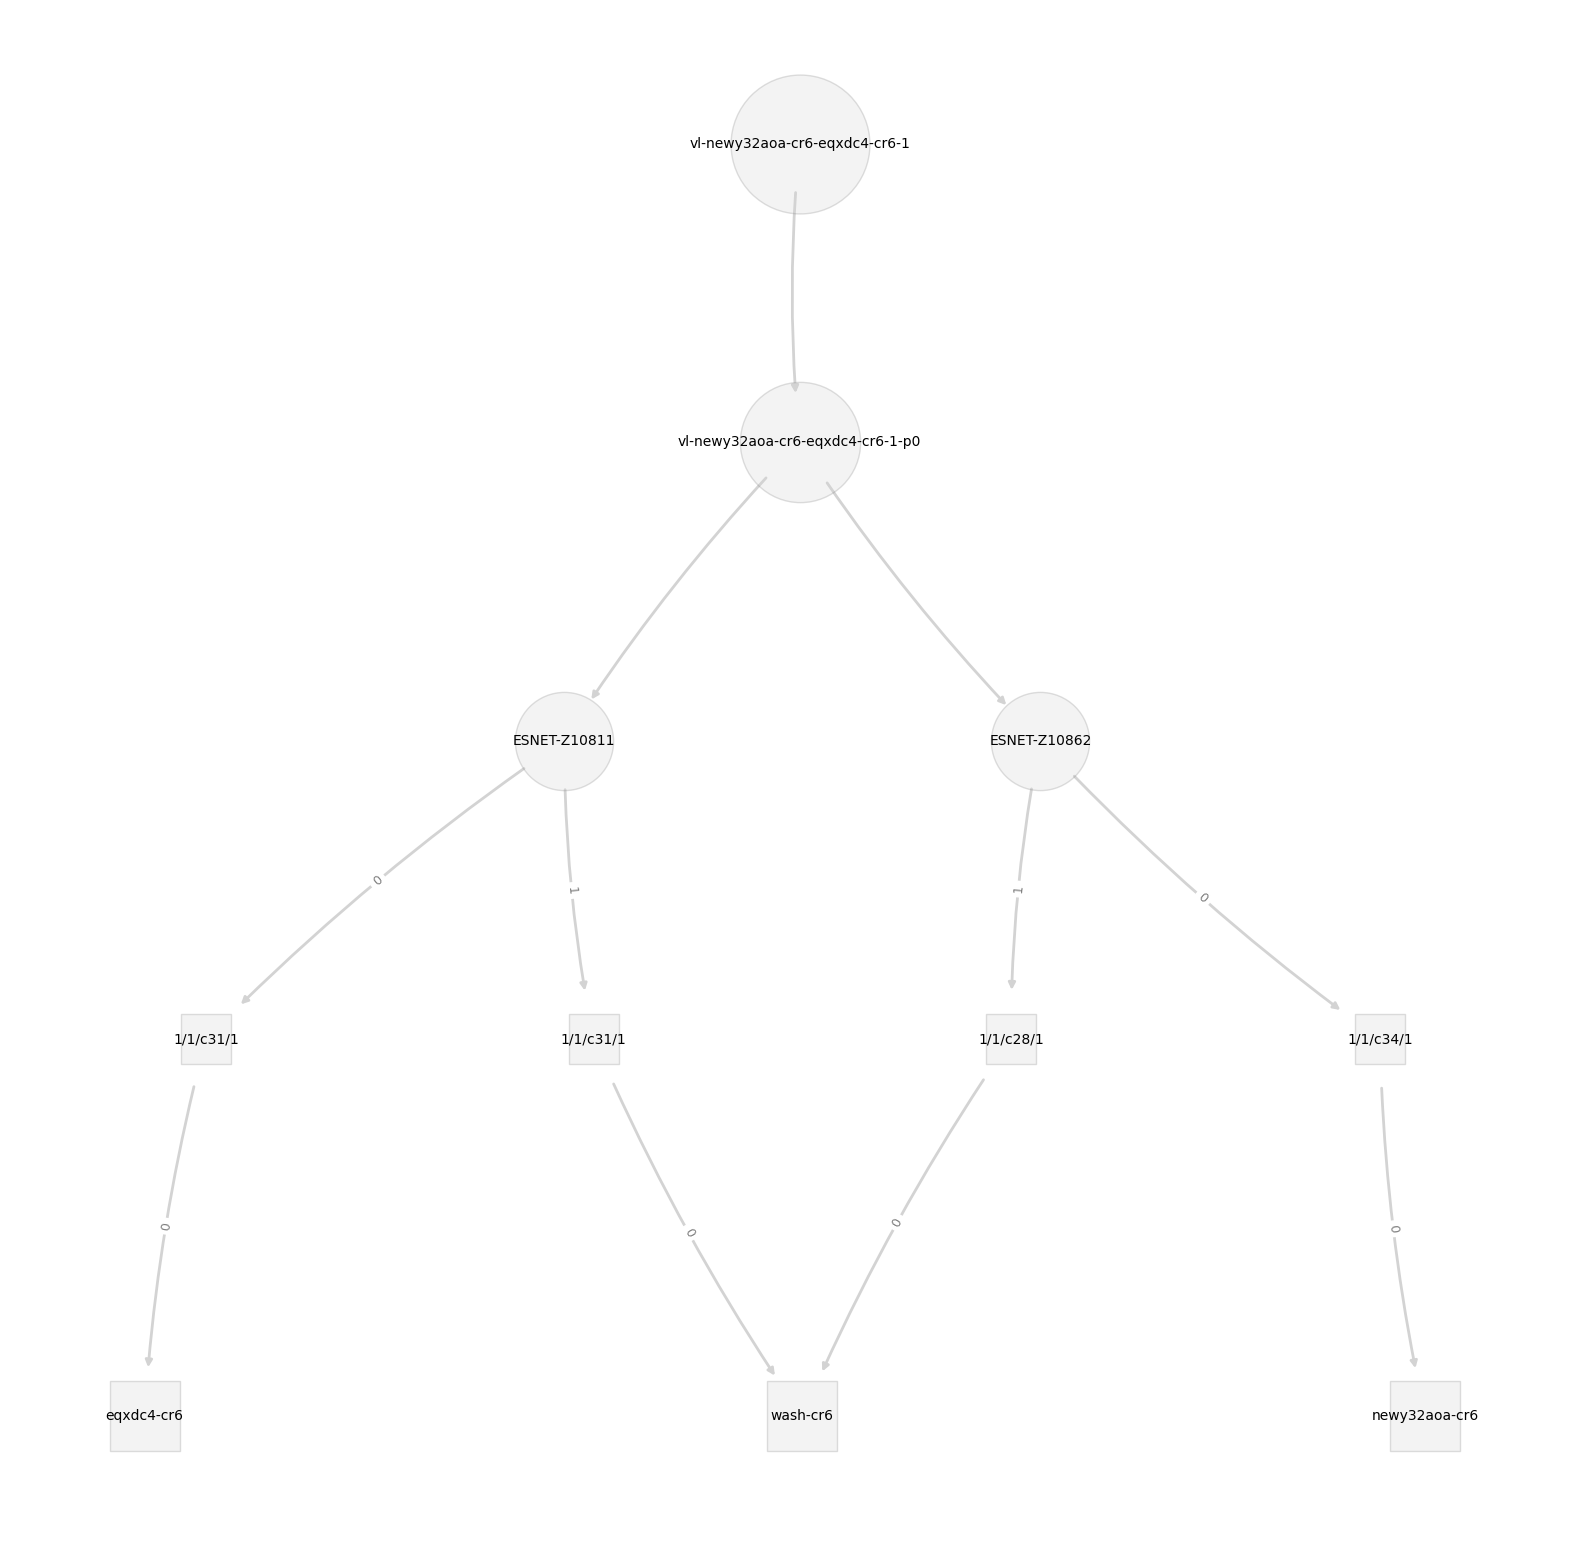

In [6]:
#--- what does the dependency graph for the vlan look like?
draw_depgraph(deps,"label","none","none",vlan)

In [7]:
#--- this seems to work well, now what happens if the vlan doesnt have an explicite path but can use any path between a and z?
#--- in this model hop count gets huge as its 3x real hop count so..

bbckts = ckts       = [(u,v) for (u,v, d) in g.edges(data=True) ]


#--- need to only look at the bb ckt subgraph
subg = g.edge_subgraph(bbckts)

#--- would be better to copy the topo, remote the old path then iterate to maximize resilience for this example
paths = nx.shortest_simple_paths(subg,a_end,z_end,weight="weight")



#--- need to convert from topology path to list of dependencies (recall ckts represented as nodes in dep)
#--- depset used to represet a specific path where in this case if any of the depset is down the entire path is down
#--- if all depsets are down then the vlan is down, if any depset is down then the vlan is considered degrated for this example
#--- in real life degraded would likely be more complicated and would have to consider capacity

max_paths = 3 #--- this is hack to demonstrate multi path
x = 1

data = nx.get_edge_attributes(subg,"type")
#pprint.pp(data)
for path in map(nx.utils.pairwise, paths):
    if x > max_paths:
        break
    hopcnt=0

    path_id = "p"+str(x)
    vlan_path = vlan+"-p"+str(x)
    deps.add_node(vlan_path,type="vlan_path",label=vlan_path,state=1)
    deps.add_edge(vlan,vlan_path,type="depends_on",weight=10,path_dep=1)


    pathlist = list(path)
    #pprint.pp(pathlist)
    for hop in pathlist:
        #pprint.pp(list(deps.in_edges))
        invhop = (hop[1],hop[0])  
        if hop not in data and invhop not in data:
            next
                  
        if hop in data.keys() and data[hop] == "ckt": 
            #---- a hop can belong to multiple dependency sets ie paths
            dep = nx.get_edge_attributes(subg,"label")[hop]
            deps.add_edge(vlan_path,dep,type="depends_on",weight=10,hop=hopcnt,depset=path_id,depends_on=1,ckt_dep=1,path_id=1)
            #print ("add edge: "+vlan + " -> "+dep+" path "+str(x)+"  hop "+str(hopcnt))
            hopcnt = hopcnt+1
        elif invhop in data.keys() and data[invhop] == "ckt":
            dep = nx.get_edge_attributes(subg,"label")[invhop]
            deps.add_edge(vlan_path,dep,type="depends_on",weight=10,hop=hopcnt,depset=path_id,depends_on=1,ckt_dep=1,path_id=1)
            #print ("add edge: "+vlan + " -> "+dep+" path "+str(x)+"  hop "+str(hopcnt))
            hopcnt = hopcnt+1
            
    x = x + 1


{'ESNET-Z10811',
 'ESNET-Z10862',
 'ESNET-Z14060',
 'eqxdc4-cr6',
 'eqxdc4-cr6:1/1/c31/1',
 'newy32aoa-cr6',
 'newy32aoa-cr6:1/1/c19/1',
 'newy32aoa-cr6:1/1/c34/1',
 'vl-newy32aoa-cr6-eqxdc4-cr6-1-p0',
 'vl-newy32aoa-cr6-eqxdc4-cr6-1-p1',
 'vl-newy32aoa-cr6-eqxdc4-cr6-1-p2',
 'vl-newy32aoa-cr6-eqxdc4-cr6-1-p3',
 'wash-cr6',
 'wash-cr6:1/1/c28/1',
 'wash-cr6:1/1/c31/1',
 'wash-cr6:2/1/c25/1'}
only show dependencies of vl-newy32aoa-cr6-eqxdc4-cr6-1


<Figure size 10000x2000 with 0 Axes>

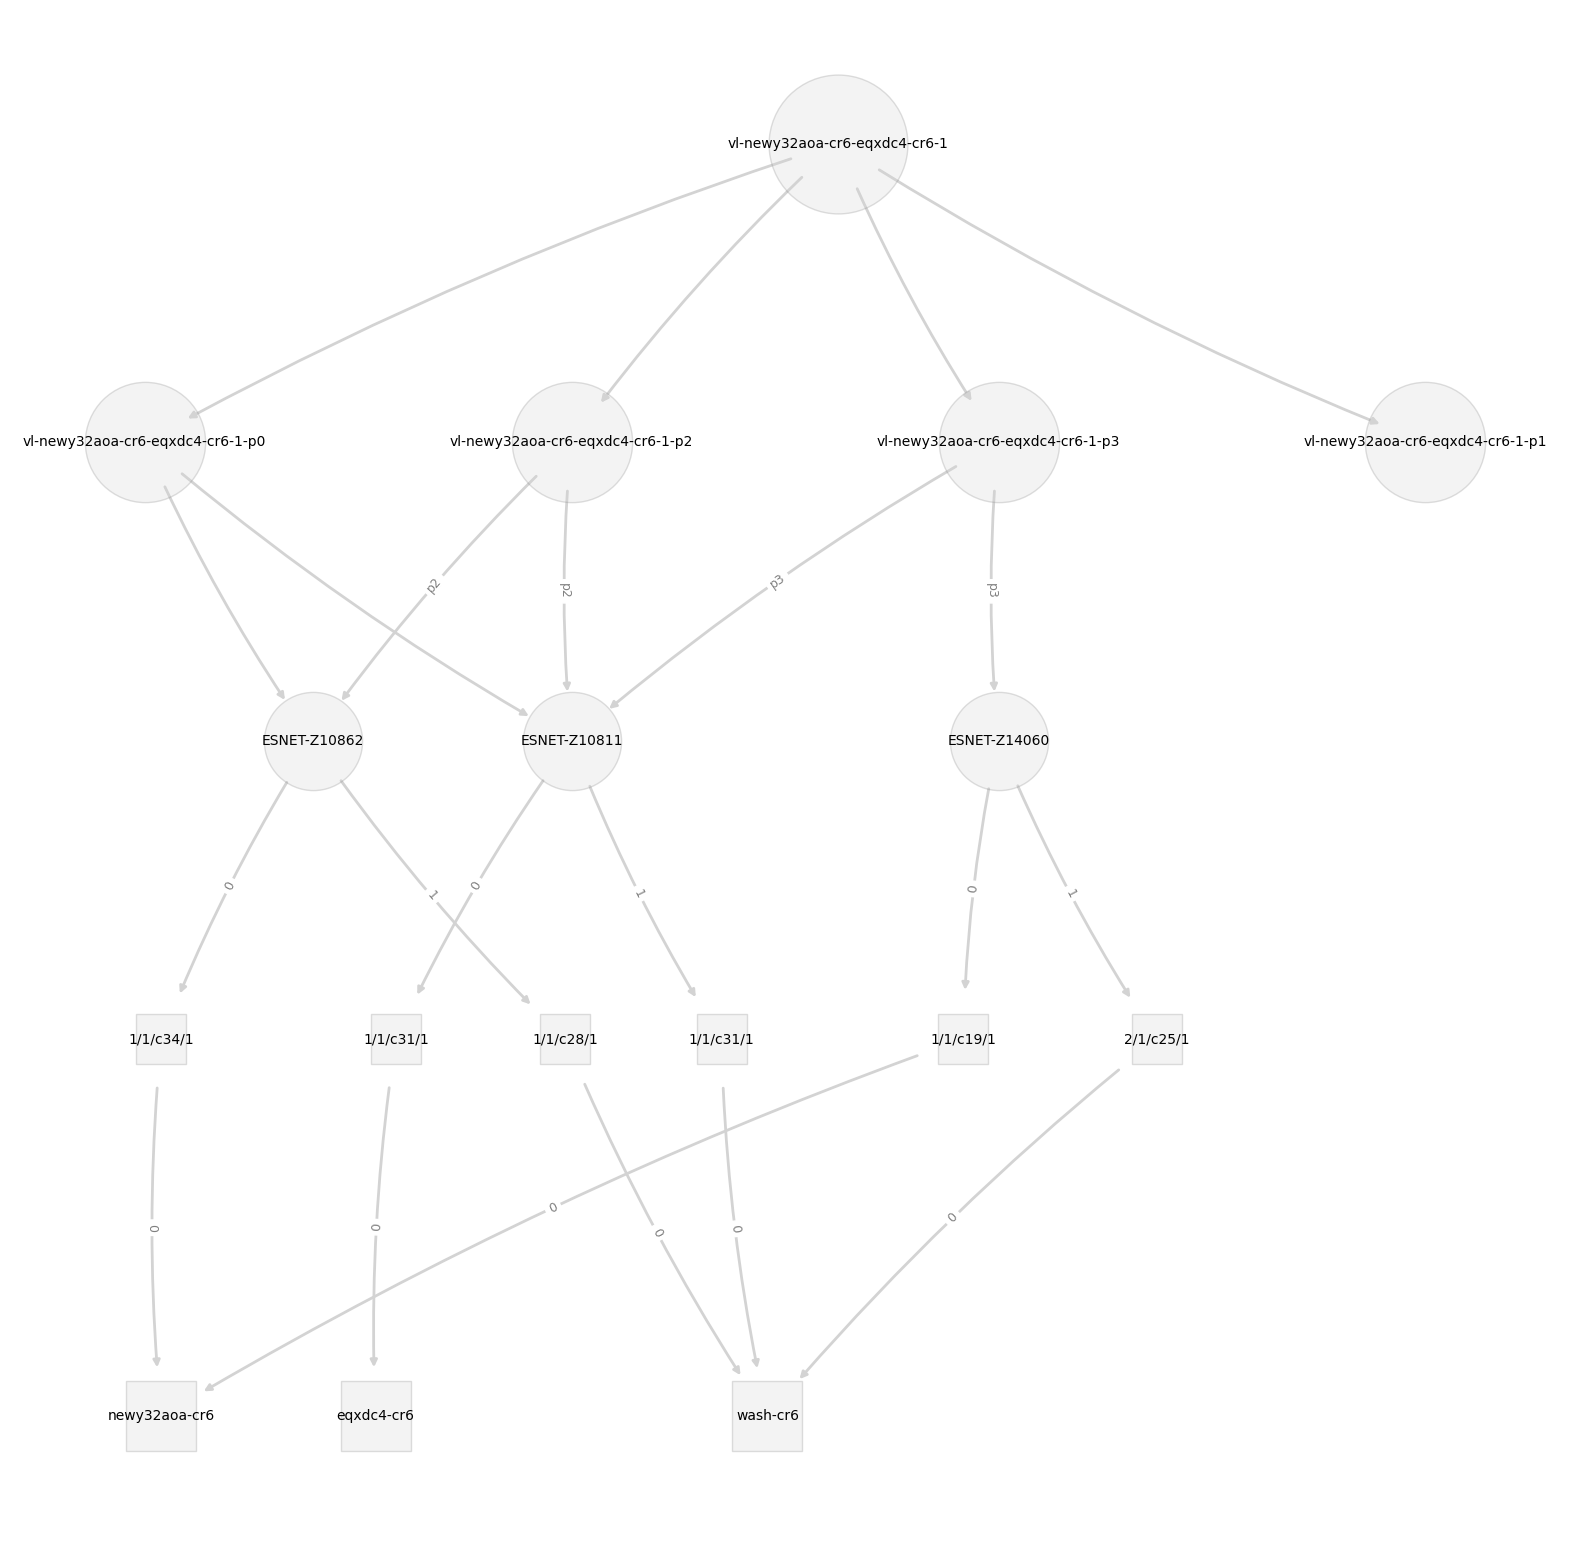

In [8]:
#---what does this vlan depend on operationally?
pprint.pp(nx.descendants(deps,vlan))
draw_depgraph(deps,"label","none","none",vlan)

In [9]:
#---- to add another layer of complexity, lets asssume that all ckts between a pair of routers rides the same dwdm system 
#---- for illustration we dont need to model the dwdm down to the segments and amps, just a logical whole entity

bbckt_data = {k:v for (k,v) in data.items() if "ckt" in v}
lut = {}
x=0
for (k,v) in bbckt_data.items():
    edge = []
    
    try:
        edge = g[k[0]][k[1]]
    except KeyError:
        try:
            edge = g[k[1]][k[0]]
        except KeyError:
            print ("not found "+str(k))
        
    #--- as this is demo code, we can rely on contents of label to infer structure     
    router_a = k[0].split('-cr6:')[0]
    router_z = k[1].split('-cr6:')[0]

    if router_a < router_z :
        dwdm_id = "DWDM-"+router_a+"-"+router_z+"-1"
    else:
        dwdm_id = "DWDM-"+router_z+"-"+router_a+"-1"


    if dwdm_id not in lut:
        lut[dwdm_id] = 1
        #print ("add "+dwdm_id)

        #--- add dwdm link to topology
        g.add_edge(router_a,router_z,key=dwdm_id,label=dwdm_id,type="dwdm",weight=1.75,capacity=2600,distance=1)

        #--- add dwdm link to dependency graph
        deps.add_node(dwdm_id,type="dwdm",weight=100,label=dwdm_id,state=1)
        
    deps.add_edge(edge['label'],dwdm_id,type="depends_on",weight=30,depset=1000,depends_on=1,dwdm_dep=1)


{'DWDM-eqxdc4-wash-1',
 'DWDM-newy32aoa-wash-1',
 'ESNET-Z10811',
 'ESNET-Z10862',
 'ESNET-Z14060',
 'eqxdc4-cr6',
 'eqxdc4-cr6:1/1/c31/1',
 'newy32aoa-cr6',
 'newy32aoa-cr6:1/1/c19/1',
 'newy32aoa-cr6:1/1/c34/1',
 'vl-newy32aoa-cr6-eqxdc4-cr6-1-p0',
 'vl-newy32aoa-cr6-eqxdc4-cr6-1-p1',
 'vl-newy32aoa-cr6-eqxdc4-cr6-1-p2',
 'vl-newy32aoa-cr6-eqxdc4-cr6-1-p3',
 'wash-cr6',
 'wash-cr6:1/1/c28/1',
 'wash-cr6:1/1/c31/1',
 'wash-cr6:2/1/c25/1'}
only show dependencies of vl-newy32aoa-cr6-eqxdc4-cr6-1


<Figure size 10000x2000 with 0 Axes>

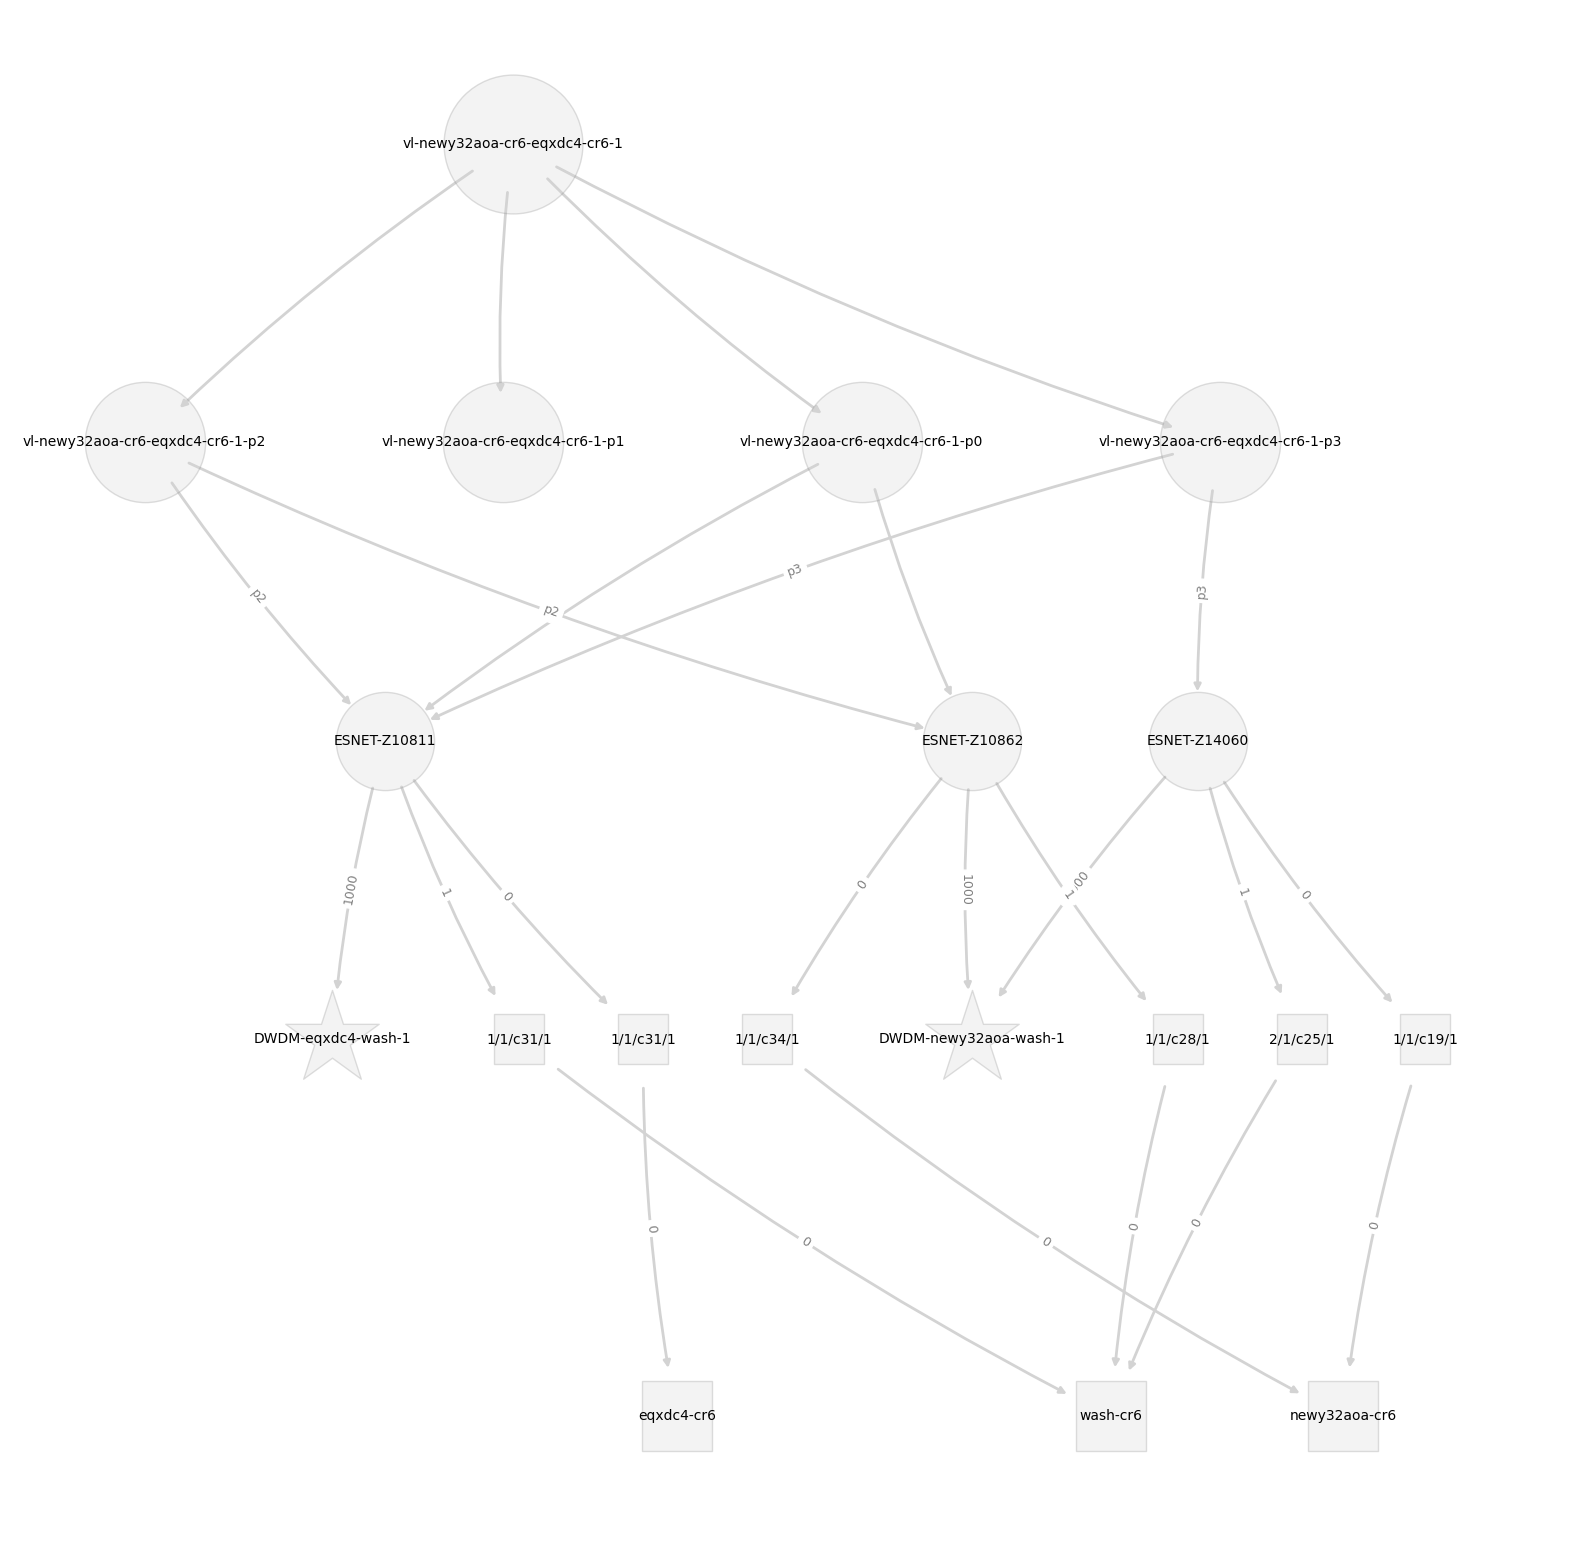

In [10]:
#---what does this vlan depend on operationally?
pprint.pp(nx.descendants(deps,vlan))
draw_depgraph(deps,"label","none","none",vlan)

Timestep: 0
Timestep: 1
Timestep: 2
Timestep: 3
Timestep: 4
Timestep: 5
Timestep: 6
Timestep: 7
Timestep: 8
Timestep: 9
Timestep: 10

Converged at time: 10
Fixed Point iterations: 11
                 component        down
0  newy32aoa-cr6:1/1/c34/1  [1.0, 1.0]
                 component        down
0  newy32aoa-cr6:1/1/c34/1  [1.0, 1.0]
1             ESNET-Z10862  [1.0, 1.0]
                          component        down
0           newy32aoa-cr6:1/1/c34/1  [1.0, 1.0]
1  vl-newy32aoa-cr6-eqxdc4-cr6-1-p0  [1.0, 1.0]
2  vl-newy32aoa-cr6-eqxdc4-cr6-1-p2  [1.0, 1.0]
3                      ESNET-Z10862  [1.0, 1.0]
                          component        down
0           newy32aoa-cr6:1/1/c34/1  [1.0, 1.0]
1  vl-newy32aoa-cr6-eqxdc4-cr6-1-p0  [1.0, 1.0]
2  vl-newy32aoa-cr6-eqxdc4-cr6-1-p2  [1.0, 1.0]
3                      ESNET-Z10862  [1.0, 1.0]
                          component        down
0           newy32aoa-cr6:1/1/c34/1  [1.0, 1.0]
1  vl-newy32aoa-cr6-eqxdc4-cr6-1-p0  [1.0, 1.0

<Figure size 10000x2000 with 0 Axes>

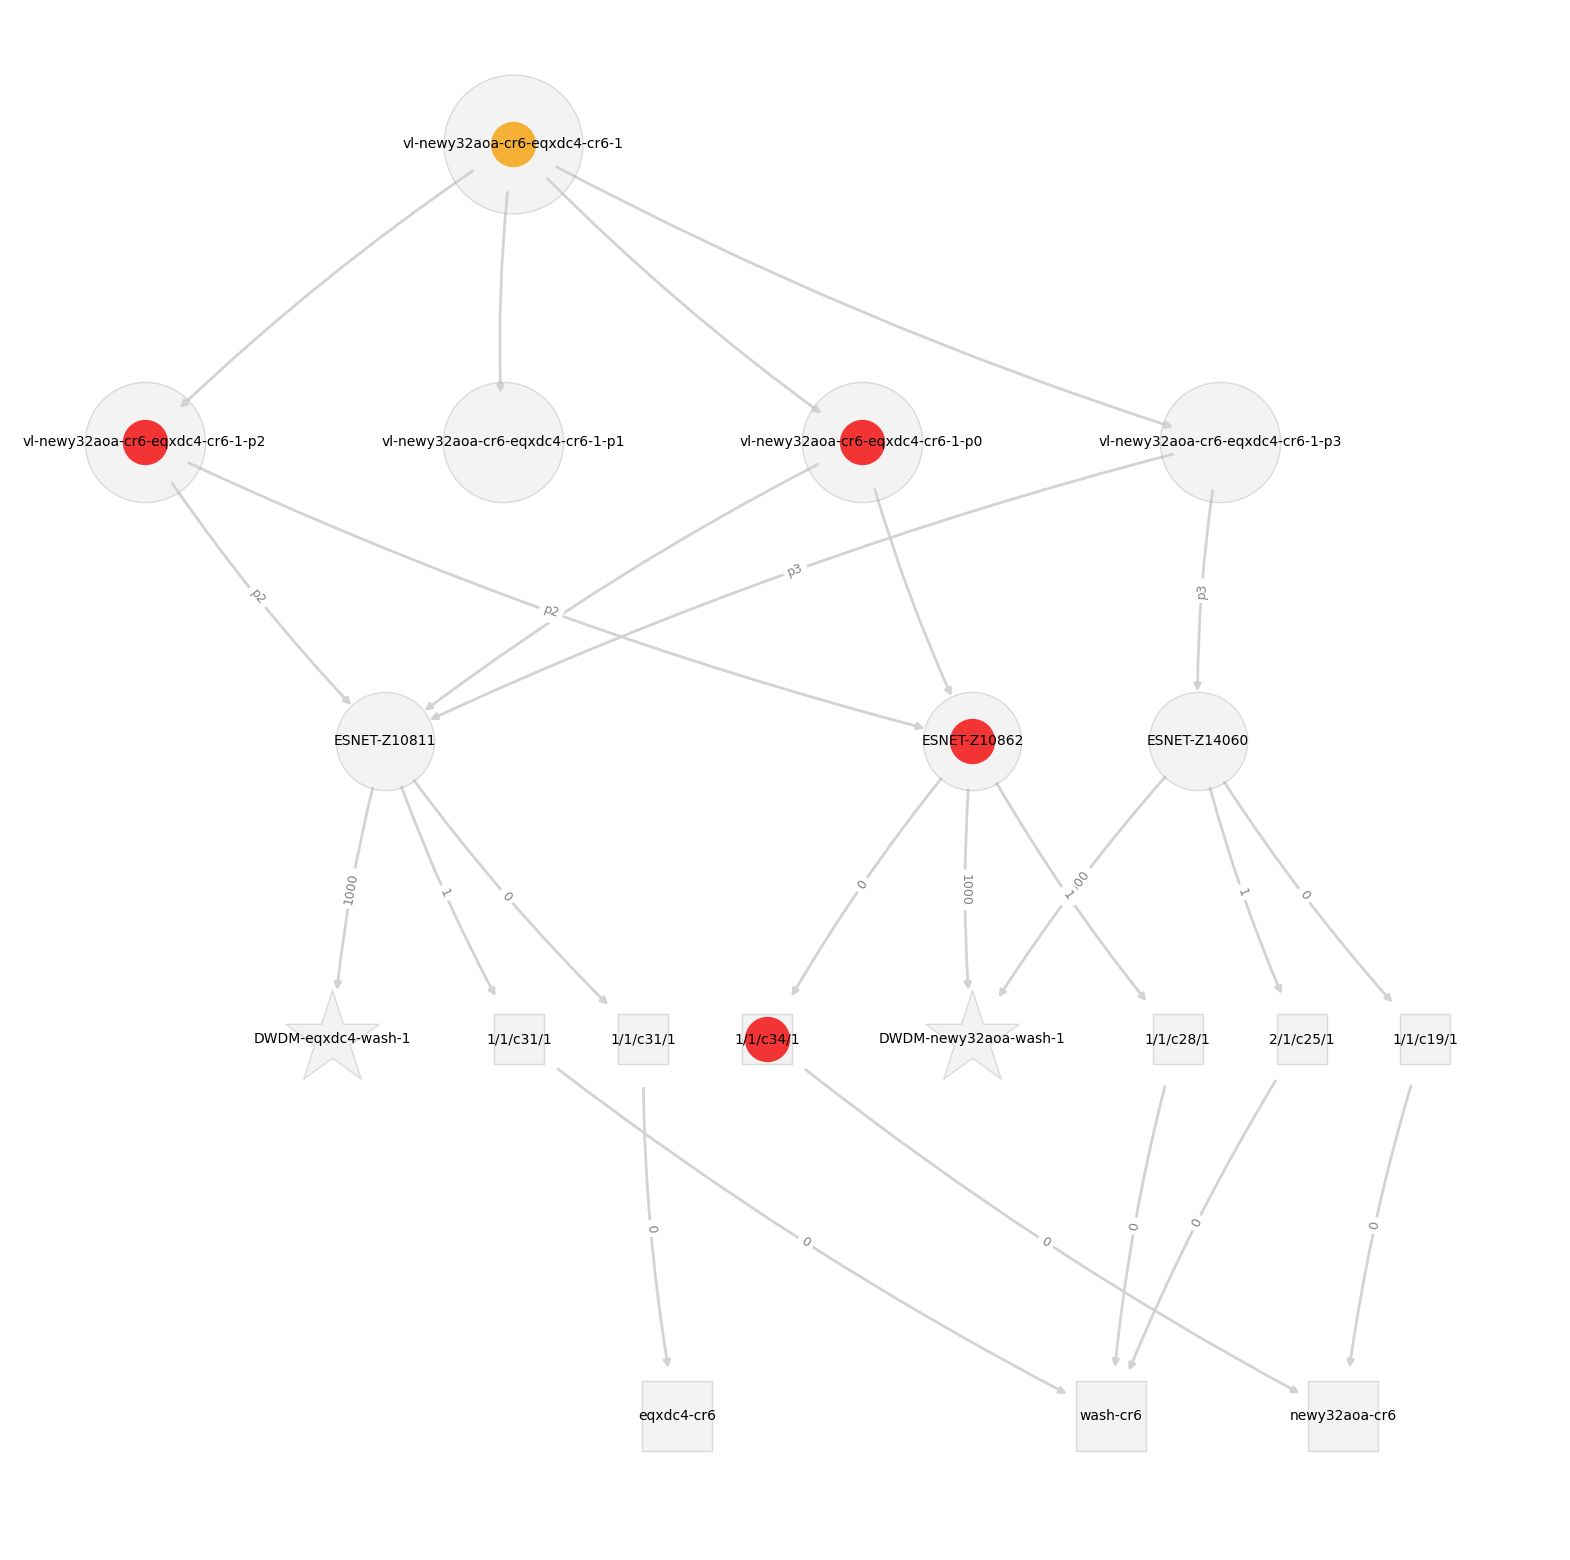

In [11]:
#---- step two lets try a simple model where you are down if all things you depend on are down
import pyreason as pr
from pyreason import Threshold

#pr.settings.verbose = True

pr.load_graph(deps)

#-- if node is IFF all dependends down
user_defined_thresholds = [
        Threshold("greater_equal", ("number", "total"), 1),
        Threshold("greater_equal", ("percent", "total"), 100)
]

pr.add_rule(pr.Rule("down(x) <-1 path_dep(x,y), down(y)","vlan down if all paths it depends on are down",custom_thresholds=user_defined_thresholds))
pr.add_rule(pr.Rule("degraded(x) <-1 path_dep(x,y), down(y)","vlan degraded if any paths it depens on are down"))
pr.add_rule(pr.Rule("down(x) <-1 ckt_dep(x,y), down(y)","path down if any ckt it depens on is down"))
pr.add_rule(pr.Rule("down(x) <-1 dwdm_dep(x,y), down(y)","ckt down if all dwdm it depens on are down",custom_thresholds=user_defined_thresholds))
pr.add_rule(pr.Rule("down(x) <-1 hw_dep(x,y), down(y)","if down if dev dependencies down",custom_thresholds=user_defined_thresholds))
pr.add_rule(pr.Rule("down(x) <-1 ep_dep(x,y), down(y)","ckt down if any ep dep is down"))



#pr.add_fact(pr.Fact(name='down-fact', component='DWDM-eqxdc4-wash-13', attribute='down', bound=[1,1], start_time=0, end_time=3))

pr.add_fact(pr.Fact("initial down", "newy32aoa-cr6:1/1/c34/1", "down", [1, 1], 0, 6, static=True))
#pr.add_fact(pr.Fact("later down", "wash-cr6", "down", [1, 1], 1, 6, static=True))



interpretation = pr.reason(timesteps=10)
pr.save_rule_trace(interpretation)

#print(interpretation)

interpretations_dict = interpretation.get_interpretation_dict()


dataframes = pr.filter_and_sort_nodes(interpretation, ['down'])

for t, df in enumerate(dataframes):
    #--- the node  to corresponding state.
    #print("Time: "+str(t))
    print(df)
    series = df['component']
    for index, comp in series.items():
        #print(comp)
        deps.nodes[comp]["down"] = 1
    #print()

#--- hacky
dataframes = pr.filter_and_sort_nodes(interpretation, ['degraded'])

for t, df in enumerate(dataframes):
    #--- the node  to corresponding state.
    #print("Time: "+str(t))
    print(df)
    series = df['component']
    for index, comp in series.items():
        #print(comp)
        deps.nodes[comp]["degraded"] = 1
    print()

    

draw_depgraph(deps,"label","down","degraded",vlan)